In [233]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import os
import numpy as np

In [234]:
# retrieve the cleaned sample data

df_reviews_raw = pd.read_parquet("C:\Source Codes\sentiment_amazon_review\dataset\sample_amazon_product_review_data_20240627_152732.parquet")

In [235]:
print("The list of columns")
column_types = df_reviews_raw.dtypes
print(column_types)

The list of columns
asin                  object
helpful_vote           int32
parent_asin           object
rating               float64
text                  object
timestamp             object
title                 object
user_id               object
verified_purchase       bool
category              object
has_image               bool
dtype: object


There are 1035 records with empty review fields which are removed. <br>
Remaining test set size is 951,769 reviews.

In [236]:
print(f"Total number of raw records: {df_reviews_raw.shape[0]}")

# Remove records with null reviews
df_reviews_raw = df_reviews_raw[df_reviews_raw["text"].isna() == False]

print(f"Total number of records remained: {df_reviews_raw.shape[0]}")

Total number of raw records: 952804
Total number of records remained: 951769


Since we collect approximately equal number of rating for each product category, it is obvious to have 3.01 as mean with 1.42 standard deviation. <br>

In [237]:
df_reviews_raw.describe()

,helpful_vote,rating
count,951769.000000,951769.000000
mean,1.457020,3.017064
std,16.223503,1.424915
min,0.000000,1.000000
25%,0.000000,2.000000
50%,0.000000,3.000000
75%,1.000000,4.000000
max,6390.000000,5.000000


From the distribution of ratings, it is obviously indicates the equal number of ratings in the sampled database.<br>
This will help us to have a balanced dataset when training the ML model for sentiment classes (positive, notr or negative).

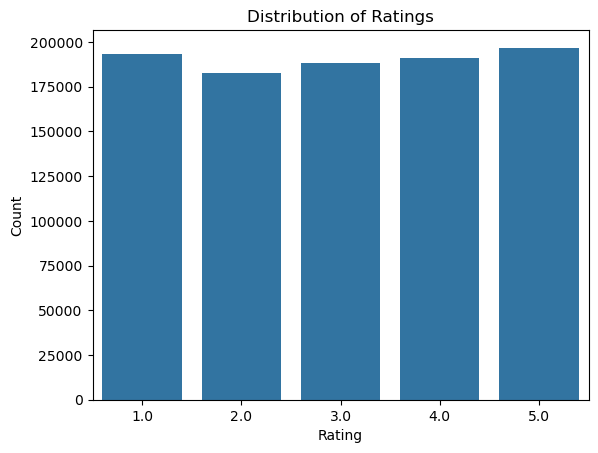

Mean rating: 3.02
Median rating: 3.0
Mode rating: 5.0


In [238]:
# 1. Distribution of ratings
plt.figure()
sns.countplot(x='rating', data=df_reviews_raw)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

mean_rating = df_reviews_raw['rating'].mean()
median_rating = df_reviews_raw['rating'].median()
mode_rating = df_reviews_raw['rating'].mode().values[0]
print(f"Mean rating: {mean_rating:.2f}")
print(f"Median rating: {median_rating}")
print(f"Mode rating: {mode_rating}")

When we check for the review length distribution, the major amount of the reviews are short reviews. Definitely we look for the correlation of length with the positive or negative reviews in further steps but at the first glance, it gives the impression that since all ratings are distributed equally but there is more of short reviews, the correlation should not be strong between rating and review length. Meanwhile, there are more than 1000 reviews with more than 1000 characters and 395 of reviews has more than 5000 characters upto review texts with 28K character. It is crazy, but data is data!

Correlation between review length and rating: -0.04 which means no correlation basically.

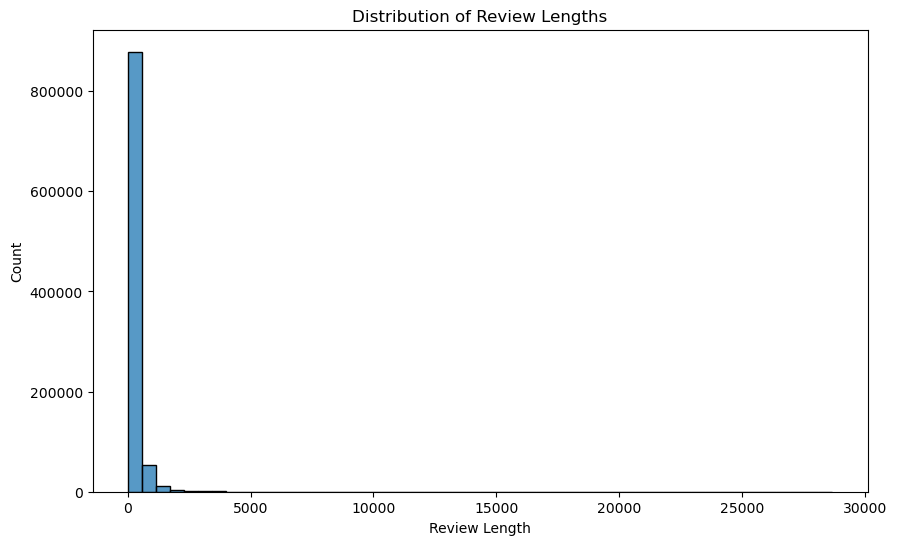

Correlation between review length and rating: -0.04


In [239]:
# 2. Review length analysis

df_reviews_raw['review_length'] = df_reviews_raw['text'].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(df_reviews_raw['review_length'], bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()

correlation = df_reviews_raw['review_length'].corr(df_reviews_raw['rating'])
print(f"Correlation between review length and rating: {correlation:.2f}")

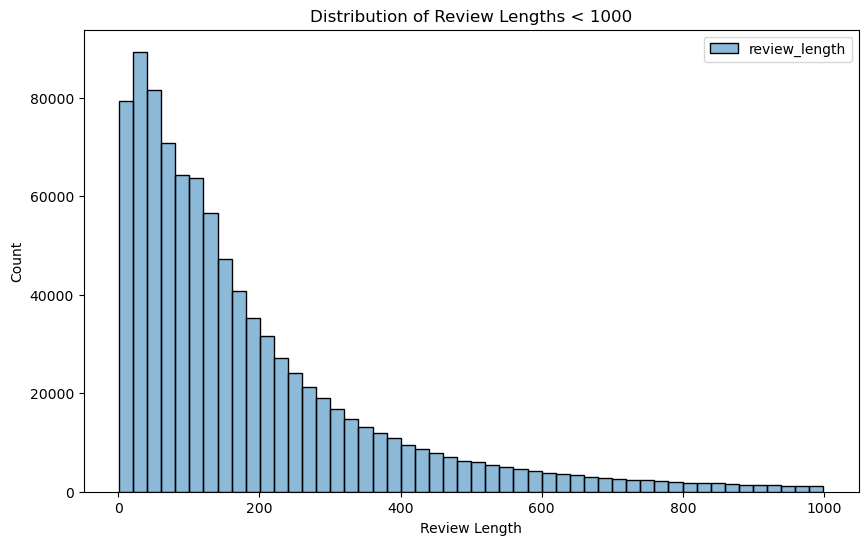

In [240]:
plt.figure(figsize=(10, 6))
sns.histplot(df_reviews_raw[df_reviews_raw['review_length'] < 1000][["review_length"]], bins=50)
plt.title('Distribution of Review Lengths < 1000')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()

In [241]:
df_reviews_raw[df_reviews_raw['review_length'] > 5000]["text"]

9620      I got the 3 Bundles of Body Wave - 18 inch, 20...
65928     Reviewing the Flex-Duo version of this with in...
70681     Important note before I start my review: check...
102096    I write to you now as a true wordworking novic...
104625    Academy's 1/350 scale model of HMS Warspite is...
                                ...                        
947481    I normally hate vampires in anything. They're ...
947675    I am a huge fan of modern day card games and d...
949251    Since its debut last March, Nintendo 3DS owner...
951281    Very impressed with this keyboard, build quali...
951782    Once upon a time, a little company called Squa...
Name: text, Length: 395, dtype: object

In compliancy with the original large dataset, the sampled dataset also has more review records recently after 2018. <br>
There exists few samples in past. Definitely, we will look for if there is correlation or tendency to be more positive or negative by time in further steps. <br>
Since the ration of samples are more in last years comparing the more historical years the average ratings by time have less deviation as shown in the second figure below. The average rating is more likely to decrease by time in recent years with increased number of reviews but we should keep in mind that we sampled equal number of ratings for each product. Maybe the ratio of positive review were higher in history. 

In [242]:
df_reviews_raw['timestamp'] = pd.to_datetime(df_reviews_raw['timestamp'].astype('int64'), unit='ms')
df_reviews_raw['date'] = df_reviews_raw['timestamp'].dt.date
df_reviews_raw['date'] = pd.to_datetime(df_reviews_raw['date'])
df_reviews_raw['review_year'] = df_reviews_raw['date'].dt.year
df_reviews_raw['review_month'] = df_reviews_raw['date'].dt.to_period('M')

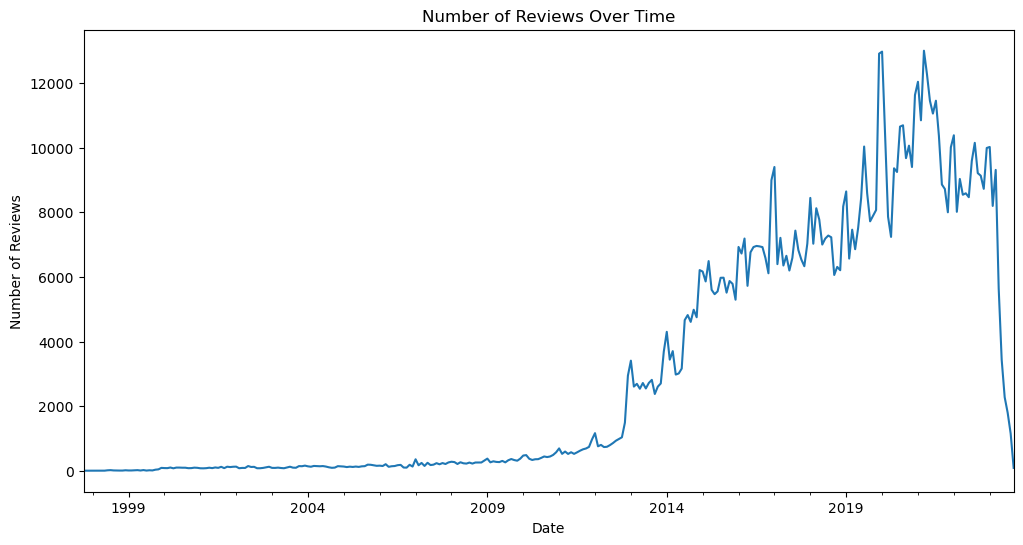

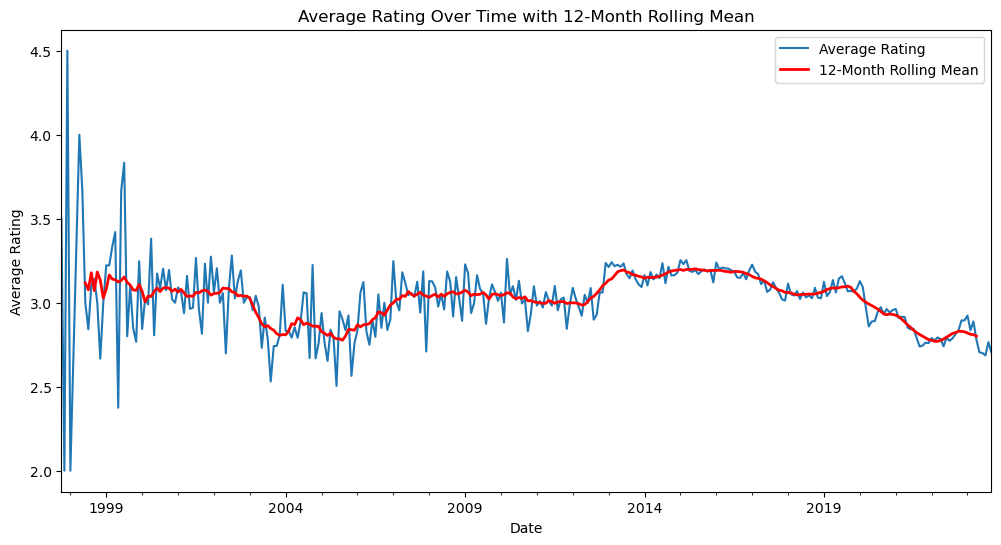

In [243]:
# 3. Time-based analysis

reviews_over_time = df_reviews_raw.groupby('review_month').size()
plt.figure(figsize=(12, 6))
reviews_over_time.plot()
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

avg_rating_over_time = df_reviews_raw.groupby('review_month')['rating'].mean()

plt.figure(figsize=(12, 6))
avg_rating_over_time.plot(label='Average Rating')

# # Calculate the rolling mean for rolling window 12 which means for recent 12 months
window_size = 12  
rolling_mean = avg_rating_over_time.rolling(window=window_size, center=True).mean()

# Plot the rolling mean
rolling_mean.plot(color='red', linewidth=2, label=f"{window_size}-Month Rolling Mean")

plt.title(f"Average Rating Over Time with {window_size}-Month Rolling Mean")
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.legend()
plt.show()

In [244]:
df_reviews_raw.head(4)

,asin,helpful_vote,parent_asin,rating,text,timestamp,title,user_id,verified_purchase,category,has_image,review_length,date,review_year,review_month
0,B09WSVFSGJ,8,B09WSVFSGJ,1.0,Don’t get it! My hair is falling out! PLEASE...,2022-08-17 23:47:24.308,My hair is falling out! DON’T get it!,AHGCCTL7DBBD7FK4RFYAJS53BGOA,True,All_Beauty,False,217,2022-08-17,2022,2022-08
1,B08YWJP9PJ,0,B08YWJP9PJ,1.0,The curved ends on almost all of these is not ...,2021-04-22 10:31:12.258,Poor design,AETGCWXC47MSMK6B2TLZ44KCFJZQ,True,All_Beauty,False,187,2021-04-22,2021,2021-04
2,B076BTRBTN,0,B076BTRBTN,1.0,Crappy & unusable.,2020-02-15 09:23:55.824,Don't waste your money,AEZBFZHVLG7CMLFKRNEDYYYMEYZQ,True,All_Beauty,False,18,2020-02-15,2020,2020-02
3,B01CDUH3XG,0,B01CDUH3XG,1.0,Felt like a limp piece of cheap fabric. Have t...,2018-07-14 15:01:00.102,One Star,AFJIWCY4AVIWGOWMFBIJZNCANRJQ,True,All_Beauty,False,91,2018-07-14,2018,2018-07


The distribution of categories in sample data is approximately equal as seen in below. <br>
Moreover the boxplot graph displays that the ratings distribution per category is also similar and equal among ratings. <br>
Because we target to have a product category agnostic solution that we can use for all categories of products in production. 

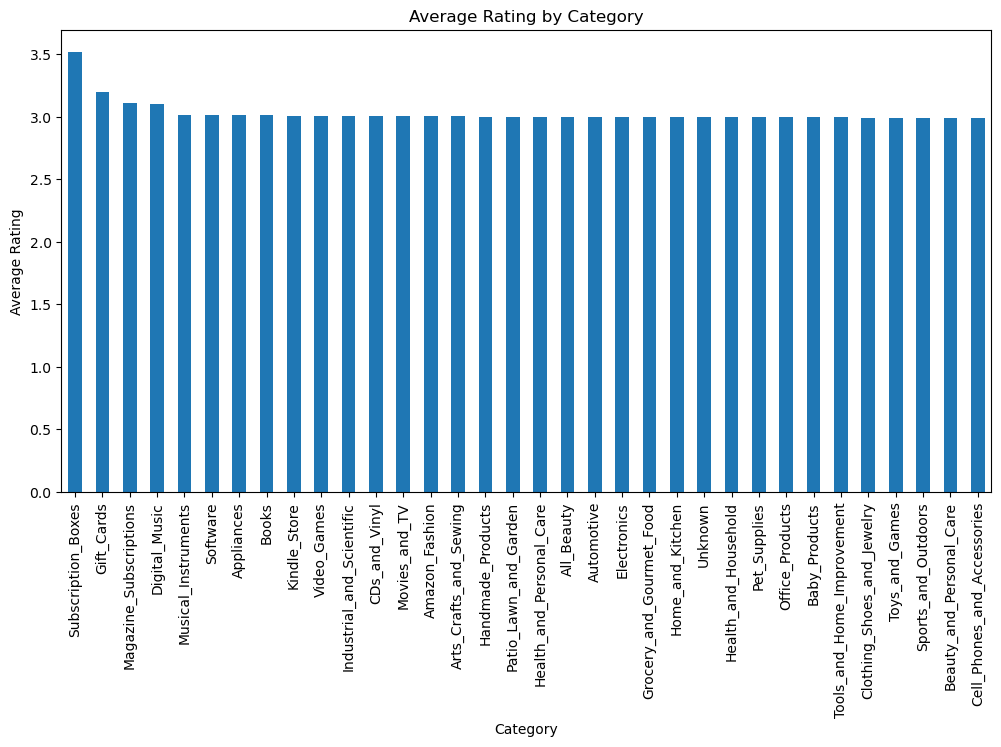

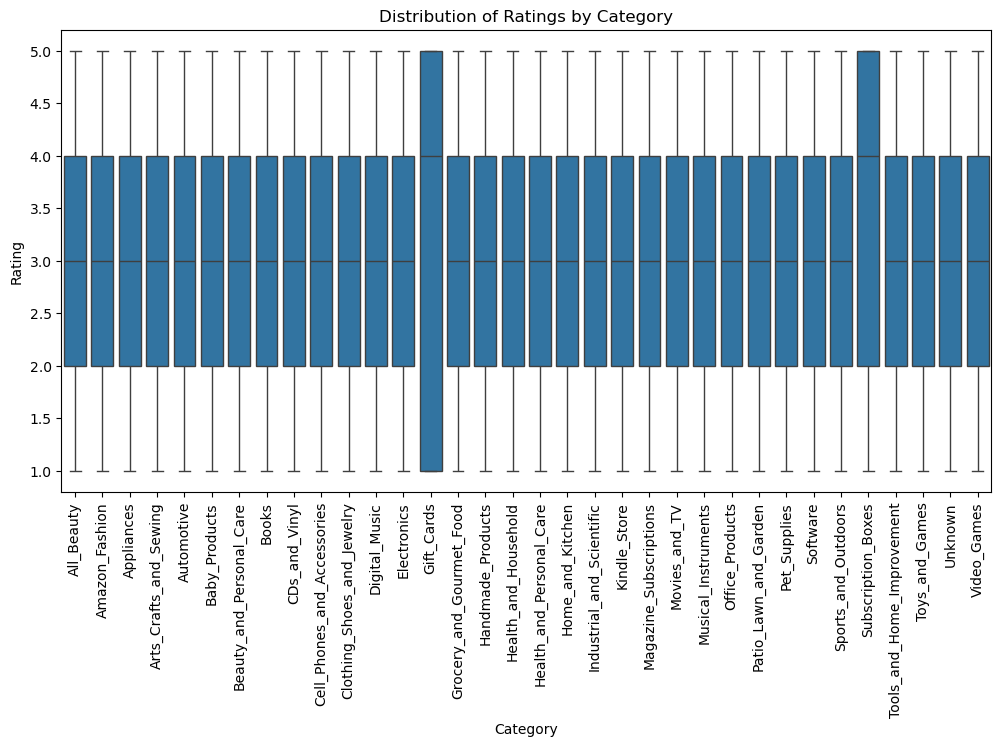

In [245]:
# 4. Category-based analysis

avg_rating_by_category = df_reviews_raw.groupby('category')['rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
avg_rating_by_category.plot(kind='bar')
plt.title('Average Rating by Category')
plt.xlabel('Category')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.show()

# Distribution of ratings within each category
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='rating', data=df_reviews_raw)
plt.title('Distribution of Ratings by Category')
plt.xlabel('Category')
plt.ylabel('Rating')
plt.xticks(rotation=90)
plt.show()

The ratio of veried purchases is quite large comparing to unverified ones in the dataset. <br>
Percentage of verified purchases: 88.73% <br>
But regardless from the difference in ratio, below boxplot diagram indicates that there is no difference of being verified or unverified over rating. 

Average rating for verified purchases: 3.03
Average rating for non-verified purchases: 2.89
Percentage of verified purchases: 88.73%


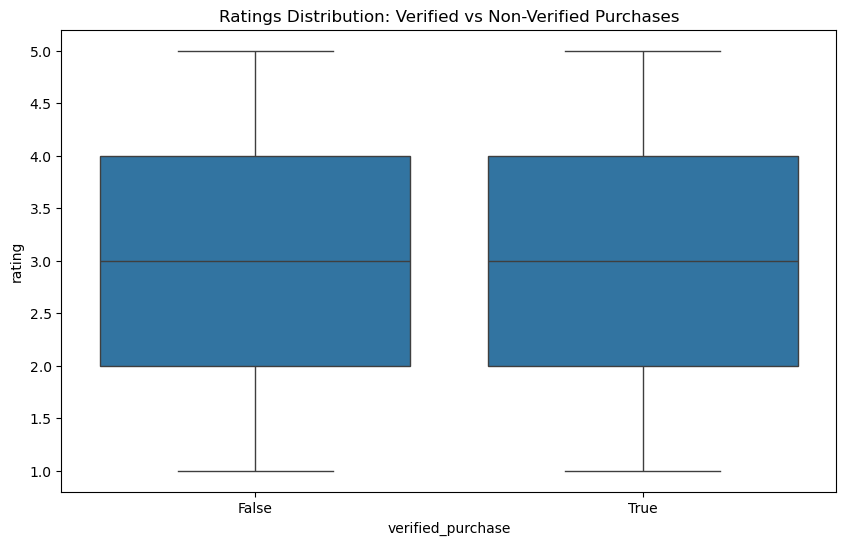

In [246]:
# 5. Verified purchase analysis

verified_avg = df_reviews_raw[df_reviews_raw['verified_purchase']]['rating'].mean()
non_verified_avg = df_reviews_raw[~df_reviews_raw['verified_purchase']]['rating'].mean()
print(f"Average rating for verified purchases: {verified_avg:.2f}")
print(f"Average rating for non-verified purchases: {non_verified_avg:.2f}")

verified_percentage = (df_reviews_raw['verified_purchase'].sum() / len(df_reviews_raw)) * 100
print(f"Percentage of verified purchases: {verified_percentage:.2f}%")

plt.figure(figsize=(10, 6))
sns.boxplot(x='verified_purchase', y='rating', data=df_reviews_raw)
plt.title('Ratings Distribution: Verified vs Non-Verified Purchases')
plt.show()

The scatter plot below displays the relationship between helfulness votes and ratings. <br>
It shows that there exist both pure negative (1 star) or pure positive (5 stars) reviews with very high helpfulness votes. <br>
No clear impact of helpfulness votes indicates a sign for ratings, and so the correlation is just -0.03 

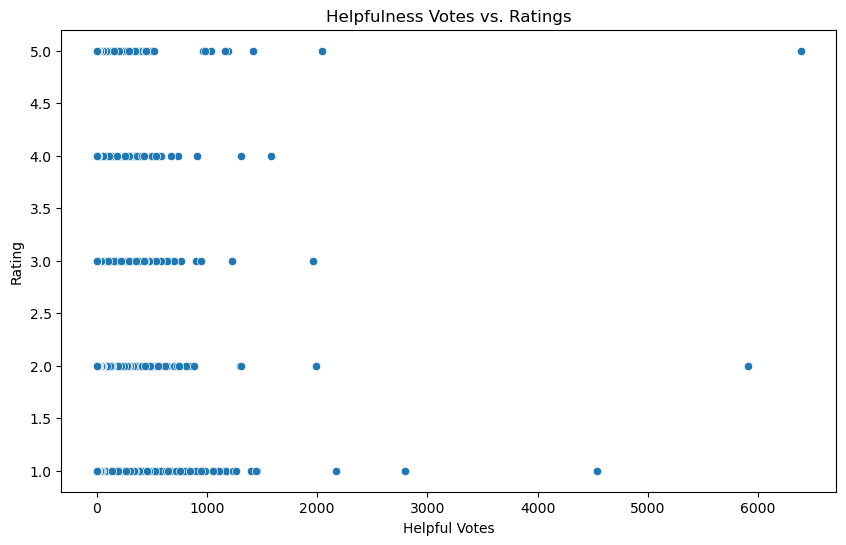

Correlation between helpful votes and rating: -0.03


In [247]:
# 6. Verified purchase analysis

plt.figure(figsize=(10, 6))
sns.scatterplot(x='helpful_vote', y='rating', data=df_reviews_raw)
plt.title('Helpfulness Votes vs. Ratings')
plt.xlabel('Helpful Votes')
plt.ylabel('Rating')
plt.show()

correlation = df_reviews_raw['helpful_vote'].corr(df_reviews_raw['rating'])
print(f"Correlation between helpful votes and rating: {correlation:.2f}")

To get a high level understanding of the frequency of some words for positive and negative reviews, generated word clouds. <br>
Eventhough there are some very common words such as "use" or "like" (probably as don't like in negatives), there are some certain words in two categories.<br>Negative reviews consists of expectation, dissappointment and price etc. <br>
Positive reviews consists of more love, greatness and easiness.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tarik.kranda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


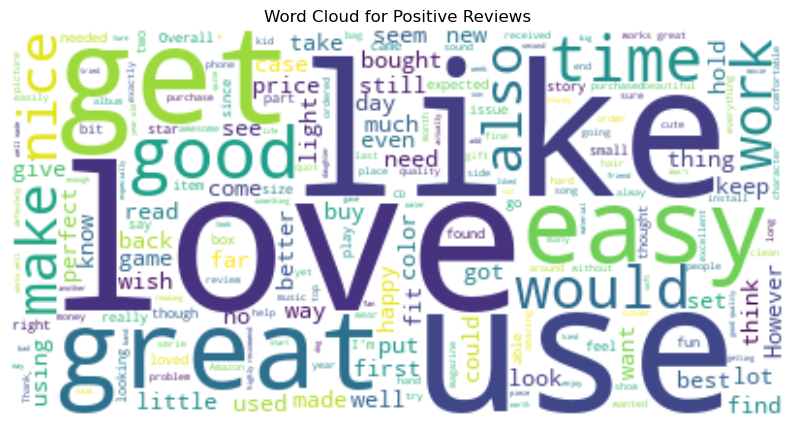

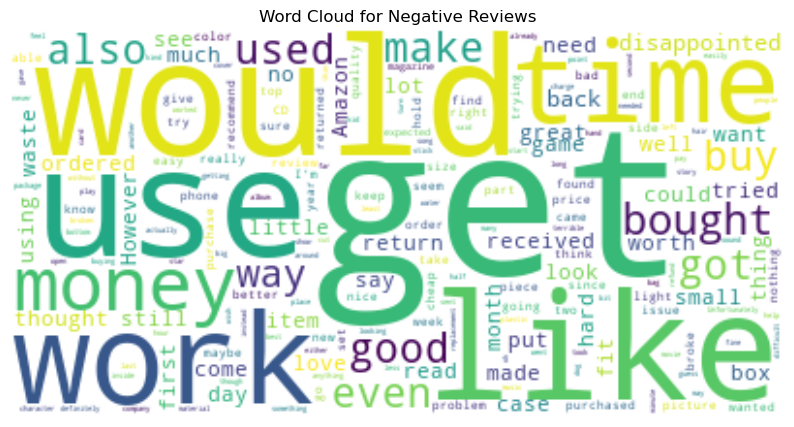

In [248]:
# 7. Word frequency analysis

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Adding br especially important because it exists in many reviews. As similar book and product words are unnecessary
custom_stop_words = {"br", "nbsp", "amp", "one", "book", "product"} 
stop_words.update(custom_stop_words)

# Removing some common words that are not useful for sentiment analysis espcially in negative views.
words_to_remove = ["don't", "aren't", "no", "nor"]
for word in words_to_remove:
    stop_words.discard(word)

def generate_wordcloud(text, title):
    wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

positive_reviews = " ".join(df_reviews_raw[df_reviews_raw['rating'] >= 4]['text'])
negative_reviews = " ".join(df_reviews_raw[df_reviews_raw['rating'] <= 2]['text'])

generate_wordcloud(positive_reviews, 'Word Cloud for Positive Reviews')
generate_wordcloud(negative_reviews, 'Word Cloud for Negative Reviews')

TextBlob package has sentiment analysis functionality inside that is a good way of building a base function to benchmark with DL based solutions.
But as you see in the scatter plot below, it does not label the sentiment correctly for many reviews. There are many 5 start reviews with negative sentiment category, and vice versa for 1 star reviews. 

It is obvious that an LLM model can provide a better solution than word scoring based lexicon analysis solutions as similar to TextBlob.

But in any case correlation between sentiment score and rating: 0.49 which means it is working partially.

TextBlob's sentiment polarity analysis works by assigning a sentiment score to a given text, ranging from -1 (very negative) to 1 (very positive). Here's an overview of how it functions:

1. Tokenization: The text is broken down into individual words or tokens[1].
2. Part-of-speech tagging: Each token is assigned a part-of-speech tag (e.g., noun, verb, adjective)[1].
3. Sentiment lexicon: TextBlob uses a pre-trained sentiment lexicon, which is a dictionary of words with associated sentiment scores[1].
4. Word scoring: Each word in the text is looked up in the sentiment lexicon to get its individual sentiment score[1].
5. Phrase analysis: TextBlob considers the context of words by analyzing phrases, not just individual words. This helps capture nuances like negations or intensifiers[1].
6. Aggregation: The individual word and phrase scores are combined to produce an overall sentiment score for the entire text[1].
7. Normalization: The final score is normalized to fall within the -1 to 1 range[1].
8. Subjectivity: In addition to polarity, TextBlob also provides a subjectivity score (0 to 1), indicating how subjective or objective the text is[1].

TextBlob's sentiment analysis is based on a simple averaging of word and phrase scores, which makes it fast and easy to use. However, it may not capture complex linguistic structures or context-dependent sentiments as effectively as more advanced machine learning models[1].

Citations:
[1] https://onlinetexttools.com/remove-words-from-text

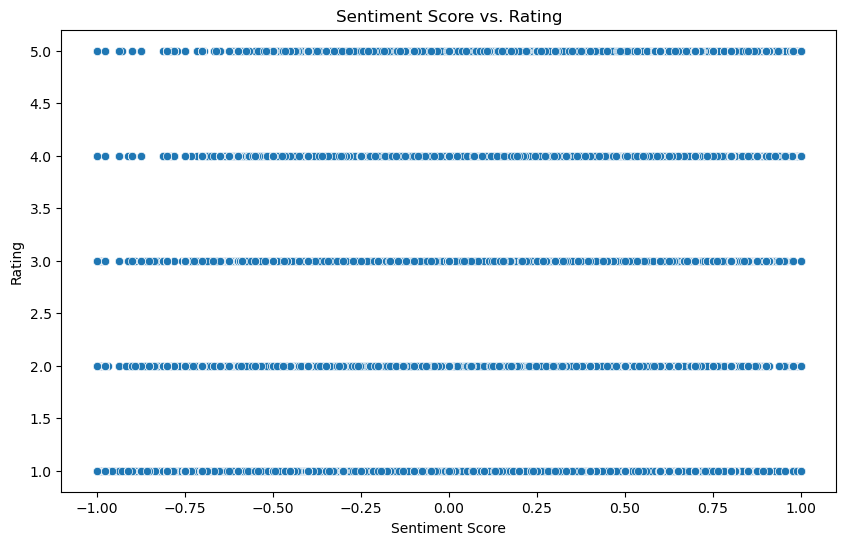

Correlation between sentiment score and rating: 0.49


In [249]:
# 8. Sentiment analysis

from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df_reviews_raw['sentiment_score'] = df_reviews_raw['text'].apply(get_sentiment)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentiment_score', y='rating', data=df_reviews_raw)
plt.title('Sentiment Score vs. Rating')
plt.xlabel('Sentiment Score')
plt.ylabel('Rating')
plt.show()

correlation = df_reviews_raw['sentiment_score'].corr(df_reviews_raw['rating'])
print(f"Correlation between sentiment score and rating: {correlation:.2f}")

In [250]:
from textblob import TextBlob

text = "I love this book! It's amazing."
blob = TextBlob(text)
polarity = blob.sentiment.polarity
subjectivity = blob.sentiment.subjectivity

print(f"Polarity: {polarity}")
print(f"Subjectivity: {subjectivity}")

Polarity: 0.6125
Subjectivity: 0.75


Percentage of reviews with images as 5.26%
The people who share their comments with images tends to give less rating (around 1s) comparing to reviews with no images as seen in below boxplot.

Percentage of reviews with images: 5.26%


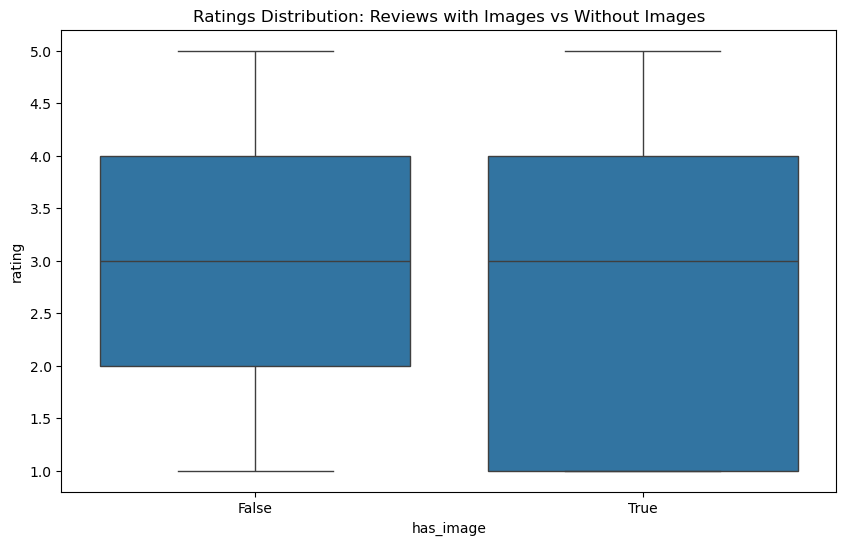

Average rating for reviews with images: 2.82
Average rating for reviews without images: 3.03


In [251]:
# 9. Image Analysis

image_percentage = (df_reviews_raw['has_image'].sum() / len(df_reviews_raw)) * 100
print(f"Percentage of reviews with images: {image_percentage:.2f}%")

plt.figure(figsize=(10, 6))
sns.boxplot(x='has_image', y='rating', data=df_reviews_raw)
plt.title('Ratings Distribution: Reviews with Images vs Without Images')
plt.show()

image_avg = df_reviews_raw[df_reviews_raw['has_image']]['rating'].mean()
no_image_avg = df_reviews_raw[~df_reviews_raw['has_image']]['rating'].mean()
print(f"Average rating for reviews with images: {image_avg:.2f}")
print(f"Average rating for reviews without images: {no_image_avg:.2f}")

In [252]:
df_reviews_raw.columns

Index(['asin', 'helpful_vote', 'parent_asin', 'rating', 'text', 'timestamp',
       'title', 'user_id', 'verified_purchase', 'category', 'has_image',
       'review_length', 'date', 'review_year', 'review_month',
       'sentiment_score'],
      dtype='object')

The correlations with the rating column, one sentence per pair:

1. rating vs review_length (-0.039294): There's virtually no relationship between the rating given and the length of the review. 
2. rating vs helpful_vote (-0.025222): The rating of a review has almost no impact on how helpful others find it.
3. rating vs sentiment_score (0.491281): As expected, higher ratings are moderately associated with more positive sentiment in the review text.
4. rating vs review_year (-0.069139): There's a weak trend towards slightly lower ratings in more recent years.

In [253]:
# Select columns you want to check correlation for
columns_to_check = ['review_length', 'helpful_vote', 'sentiment_score', 'review_year', 'rating']

correlation_matrix = df_reviews_raw[columns_to_check].corr()

print("Correlation matrix:")
print(correlation_matrix)

# Get correlation with rating specifically
rating_correlation = correlation_matrix['rating'].sort_values(ascending=False)

print("\nCorrelations with rating:")
print(rating_correlation)

Correlation matrix:
                 review_length  helpful_vote  sentiment_score  review_year  \
review_length         1.000000      0.103290        -0.067404    -0.174662   
helpful_vote          0.103290      1.000000        -0.016139    -0.045737   
sentiment_score      -0.067404     -0.016139         1.000000    -0.054040   
review_year          -0.174662     -0.045737        -0.054040     1.000000   
rating               -0.039294     -0.025222         0.491281    -0.069139   

                   rating  
review_length   -0.039294  
helpful_vote    -0.025222  
sentiment_score  0.491281  
review_year     -0.069139  
rating           1.000000  

Correlations with rating:
rating             1.000000
sentiment_score    0.491281
helpful_vote      -0.025222
review_length     -0.039294
review_year       -0.069139
Name: rating, dtype: float64


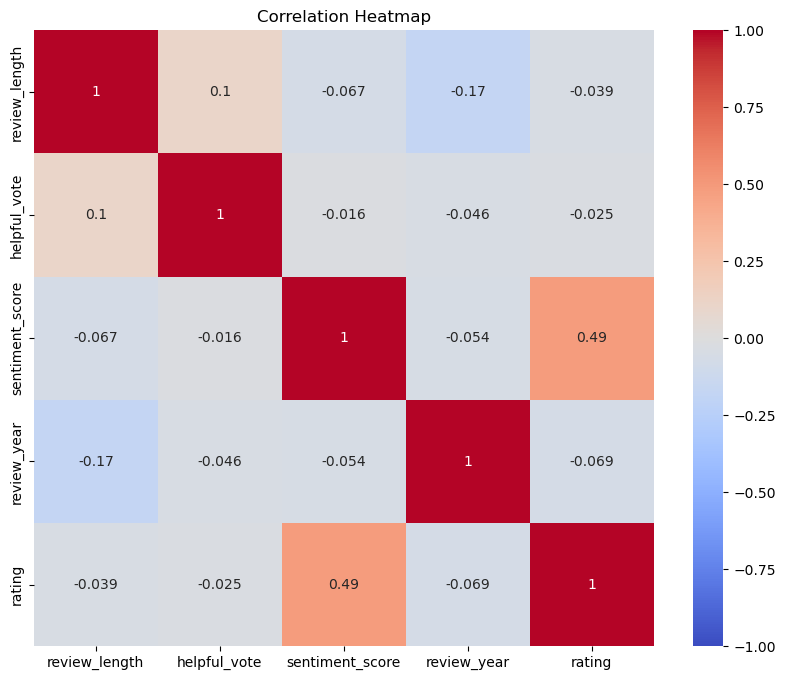

In [254]:

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.show()